# Approximating Koopman eigenfunctions using EDMD
In this tutorial, we use EDMD to learn approximate Koopman eigenfunctions for the
following two-dimensional, linear system (example from [Rowley, Williams & Kevrekidis,
 _"IPAM MTWS4"_, 2014](http://helper.ipam.ucla.edu/publications/mtws4/mtws4_12328.pdf)):

$$
{\bf x}_{k+1} = \begin{bmatrix} 0.8 & -0.05\\ 0 & 0.7\end{bmatrix}{\bf x}_k,
$$
where ${\bf x} = [x, y]^T$. Polynomial functions $x^iy^j$ with $i,j\in [0,3]$ up to
order 3 are used as basis functions. The true eigenfunctions and eigenvalues can be
approximated as follows:
$$
\varphi_{ij}(x,y) \approx (0.894x - 0.447y)^i y^j\quad \text{for}\quad i,
j\in\mathbb{N}\\
\lambda_{ij} = (0.8)^i(0.7)^j
$$

In [1]:
import pykoopman as pk
from pykoopman.common import Linear2Ddynamics
import scipy
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Collect training data

In [2]:
# Create instance of the dynamical system
sys = Linear2Ddynamics()

# Collect training data
n_pts = 51
n_int = 1
xx, yy = np.meshgrid(np.linspace(-1, 1, n_pts), np.linspace(-1, 1, n_pts))
x = np.vstack((xx.flatten(), yy.flatten()))
n_traj = x.shape[1]

X, Y = sys.collect_data(x, n_int, n_traj)

[Text(0, 0.5, '$x_2$'), Text(0.5, 0, '$x_1$')]

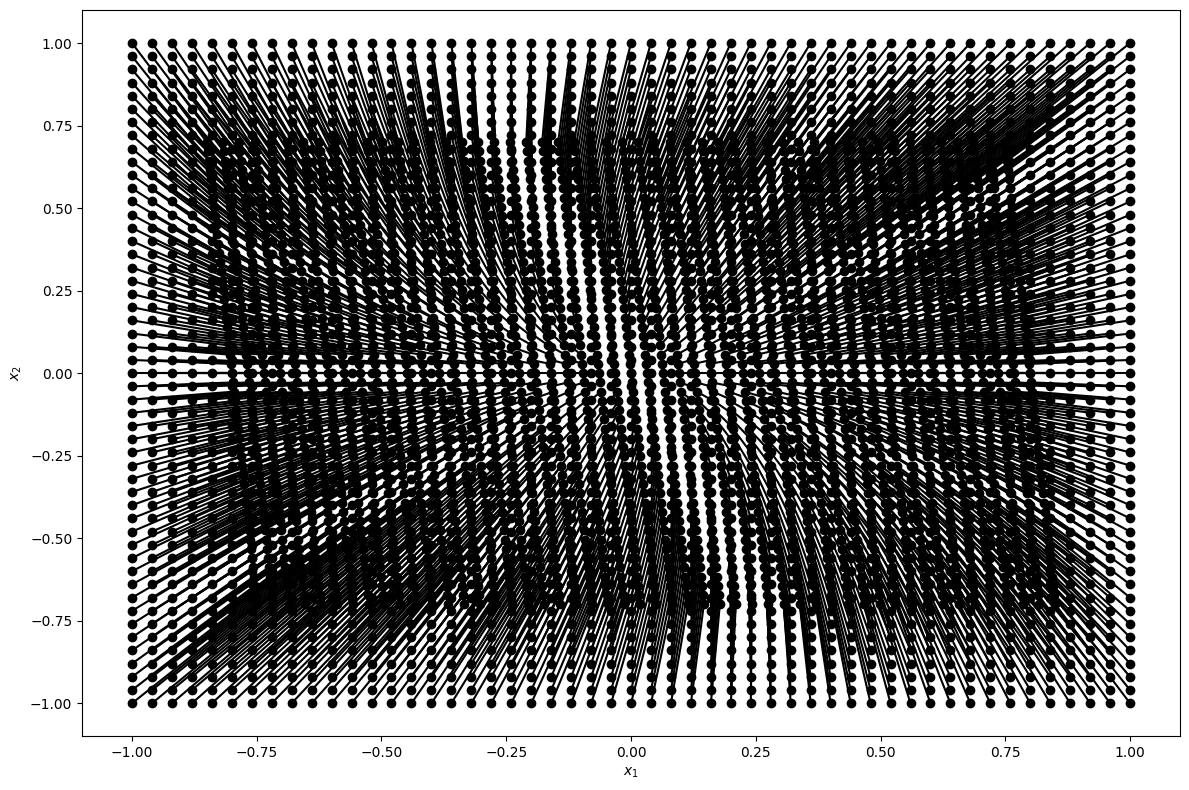

In [3]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 8))
for traj_idx in range(n_traj):
    axs.plot([X[0, traj_idx::n_traj], Y[0, traj_idx::n_traj]],
             [X[1, traj_idx::n_traj], Y[1, traj_idx::n_traj]], '-ok')
axs.set(ylabel=r'$x_2$',
        xlabel=r'$x_1$')

# Compute and visualize the true eigenfunctions and -values

[1.     0.8    0.7    0.64   0.56   0.512  0.49   0.448  0.392  0.3584
 0.343  0.2744]


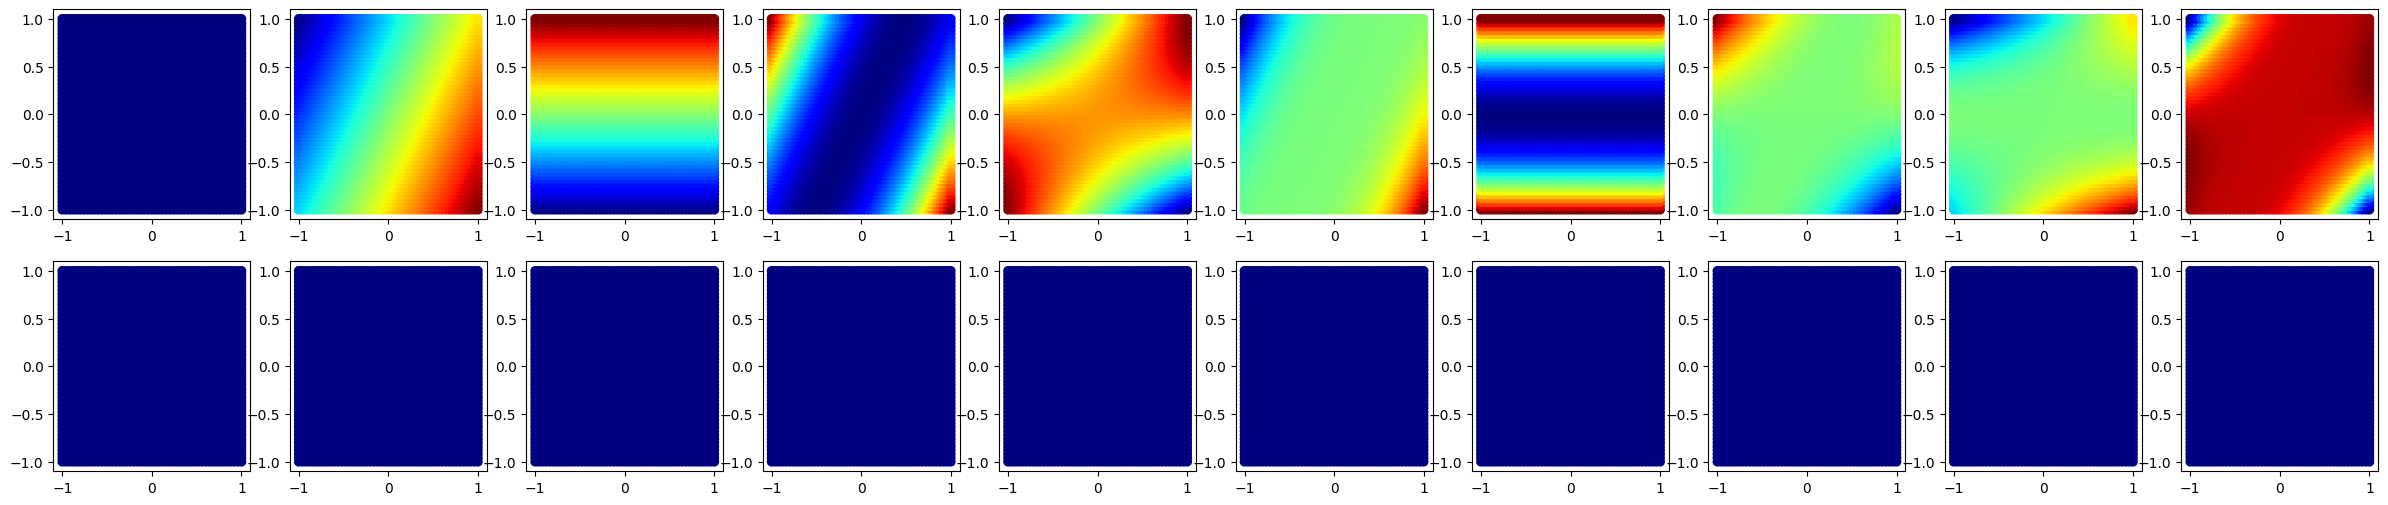

In [4]:
degree = 3
true_efuns = np.zeros((X.shape[1], 12))
true_evals = np.zeros(12)
counter = 0
for i in range(degree+1):
    for j in range(degree+1):
        if i*j <= degree:
            true_evals[counter] = (0.8**i) * (0.7**j)
            # tmp = ((0.894 * xx - 0.447 * yy)**i) * (yy**j)
            # true_efuns[:, counter] = tmp.flatten()
            true_efuns[:, counter] = ((0.894 * x[0, :] - 0.447 * x[1, :])**i) * \
                                     (x[1, :]**j)
            counter += 1

sort_idx = np.argsort(true_evals)
sort_idx = sort_idx[::-1]
true_evals = true_evals[sort_idx]
true_efuns = true_efuns[:, sort_idx]
sys.visualize_modes(X, true_efuns)
print(true_evals)

### Approximate eigenfunctions and eigenvalues using EDMD and polynomial basis functions

In [5]:
EDMDc = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model = pk.Koopman(observables=obsv, regressor=EDMDc)
model.fit(X.T, y=Y.T)

print(model.eigenvalues)
sys.visualize_modes(X, model.eigenfunctions)

[1.   +0.j 0.8  +0.j 0.7  +0.j 0.64 +0.j 0.343+0.j 0.392+0.j 0.56 +0.j
 0.512+0.j 0.49 +0.j 0.448+0.j]


AttributeError: 'EDMD' object has no attribute 'kef_'